In [ ]:
# GWR and Clustering model for Brazilian birth and death children rate, focusing in North of Brazil

### Import of libraries

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mgwr.gwr import GWR
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap
from libpysal.weights import Queen
from sklearn.preprocessing import StandardScaler

In [178]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


In [4]:
pd.set_option('display.max_columns', None)

### Loading the dataset


In [5]:
caminho_shapefile = "/Users/yusukehayashibara/Downloads/BR_Municipios_2023/BR_Municipios_2023.shp"
mapa = gpd.read_file(caminho_shapefile)

df = pd.read_csv('/Users/yusukehayashibara/Downloads/my_data.csv')

In [6]:
df

,CODMUN,total_obito,obito_hospital,obito_estab_saude,obito_domicilio,sim_media_peso,qtd_filho_morto,qtd_filho_vivo,sexo_masculino,sexo_feminino,gravidez_unica,gravidez_dupla,gravidez_tripla,esc_0,esc_1,esc_2,esc_3,esc_4,esc_5,parto_vaginal,parto_cesario,raca_branca,raca_preta,raca_amarela,raca_parda,raca_indigena,idade_mae,num_estabelecimentos,total_nascimento,nascimento_hospital,nascimento_estab_saude,nascimento_domicilio,media_consultas,sinasc_media_peso,kotelchuck_1,kotelchuck_2,kotelchuck_3,kotelchuck_4,kotelchuck_5,total_geral,frac_obito_geral
0,110001,0.0,0.000000,0.000000,0.000000,NaN,0.228571,1.114286,0.771429,0.228571,1.000000,0.000000,0.000000,0.000000,0.057143,0.171429,0.514286,0.085714,0.142857,0.285714,0.714286,0.200000,0.000000,0.000000,0.628571,0.142857,26.657143,2,35.0,1.000000,0.000000,0.000000,8.200000,3209.000000,0.000000,0.142857,0.114286,0.057143,0.657143,35.0,0.000000
1,110002,19.0,1.000000,0.000000,0.000000,2215.315789,0.252853,0.920544,0.524583,0.475417,0.982002,0.017998,0.000000,0.000878,0.020632,0.200615,0.518437,0.065847,0.192713,0.272608,0.727392,0.242318,0.066286,0.011853,0.677349,0.000878,26.413960,8,2259.0,0.998229,0.000885,0.000000,8.689243,3219.460381,0.000443,0.142541,0.041169,0.068172,0.746791,2278.0,0.008341
2,110004,12.0,0.916667,0.000000,0.083333,2376.111111,0.241689,0.842216,0.516623,0.483377,0.984697,0.015303,0.000000,0.002639,0.025858,0.154617,0.439578,0.075462,0.301319,0.204222,0.795251,0.315040,0.055937,0.005277,0.575726,0.046438,27.394723,6,1883.0,0.989910,0.009559,0.000531,9.102509,3206.366968,0.000000,0.097716,0.049389,0.063197,0.777483,1895.0,0.006332
3,110005,0.0,0.000000,0.000000,0.000000,NaN,0.294574,1.100775,0.573643,0.426357,1.000000,0.000000,0.000000,0.000000,0.007752,0.186047,0.573643,0.038760,0.193798,0.062016,0.937984,0.403101,0.038760,0.000000,0.542636,0.000000,26.232558,1,129.0,0.992248,0.000000,0.000000,8.914729,3358.124031,0.000000,0.116279,0.007752,0.023256,0.852713,129.0,0.000000
4,110006,0.0,0.000000,0.000000,0.000000,NaN,0.000000,1.400000,0.600000,0.400000,1.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.800000,0.000000,0.000000,1.000000,0.000000,0.000000,0.200000,0.000000,0.600000,0.000000,24.200000,1,5.0,0.400000,0.000000,0.000000,10.000000,3176.000000,0.000000,0.200000,0.000000,0.000000,0.800000,5.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,522190,0.0,0.000000,0.000000,0.000000,NaN,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,1,1.0,0.000000,1.000000,0.000000,4.000000,3200.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000
3905,522200,0.0,0.000000,0.000000,0.000000,NaN,0.247863,1.136752,0.495726,0.504274,1.000000,0.000000,0.000000,0.000000,0.025641,0.196581,0.564103,0.051282,0.162393,0.538462,0.461538,0.256410,0.025641,0.000000,0.717949,0.000000,27.341880,3,117.0,1.000000,0.000000,0.000000,8.000000,3178.777778,0.017094,0.034188,0.042735,0.094017,0.811966,117.0,0.000000
3906,522205,0.0,0.000000,0.000000,0.000000,NaN,0.540230,1.126437,0.563218,0.436782,0.988506,0.000000,0.000000,0.000000,0.011494,0.287356,0.586207,0.034483,0.057471,0.172414,0.827586,0.264368,0.022989,0.000000,0.712644,0.000000,23.471264,1,87.0,1.000000,0.000000,0.000000,8.402299,3174.850575,0.000000,0.011494,0.045977,0.080460,0.850575,87.0,0.000000
3907,522220,0.0,0.000000,0.000000,0.000000,NaN,0.500000,1.500000,0.500000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,20.000000,1,2.0,0.500000,0.000000,0.000000,7.500000,3462.500000,0.000000,1.000000,0.000000,0.000000,0.000000,2.0,0.000000


### Feature Engineering
The escolarity and Kotelchuck Index are currently represented as the proportion of each class. However, creating many columns for each class is not ideal, especially considering our plan to implement a Geographically Weighted Regression (GWR) model. Therefore, we will group the data more simply:

- For escolarity, we will categorize it into low escolarity and high escolarity.

- For the Kotelchuck Index, we will group it into low Kotelchuck and high Kotelchuck.

This approach will simplify the feature space and support a more efficient modeling process.

In [7]:
df['perc_baixa_esc'] = df['esc_0'] + df['esc_1'] + df['esc_2']
df.drop(columns=['esc_0', 'esc_1', 'esc_2'], inplace=True)

df['perc_alta_esc'] = df['esc_3'] + df['esc_4'] + df['esc_5']
df.drop(columns=['esc_3', 'esc_4', 'esc_5'], inplace=True)

df['perc_baixo_kot'] = df['kotelchuck_1'] + df['kotelchuck_2'] + df['kotelchuck_3']
df.drop(columns=['kotelchuck_1', 'kotelchuck_2', 'kotelchuck_3'], inplace=True)

df['perc_alto_kot'] = df['kotelchuck_4'] + df['kotelchuck_5']
df.drop(columns=['kotelchuck_4', 'kotelchuck_5'], inplace=True)

# df['obito_estab_saude'] = df['obito_estab_saude'] + df['obito_hospital']
# df.drop(columns=['obito_hospital'], inplace=True)

# df['nascimento_estab_saude'] = df['nascimento_estab_saude'] + df['nascimento_hospital']
# df.drop(columns=['nascimento_hospital'], inplace=True)

In [8]:
df

,CODMUN,total_obito,obito_hospital,obito_estab_saude,obito_domicilio,sim_media_peso,qtd_filho_morto,qtd_filho_vivo,sexo_masculino,sexo_feminino,gravidez_unica,gravidez_dupla,gravidez_tripla,parto_vaginal,parto_cesario,raca_branca,raca_preta,raca_amarela,raca_parda,raca_indigena,idade_mae,num_estabelecimentos,total_nascimento,nascimento_hospital,nascimento_estab_saude,nascimento_domicilio,media_consultas,sinasc_media_peso,total_geral,frac_obito_geral,perc_baixa_esc,perc_alta_esc,perc_baixo_kot,perc_alto_kot
0,110001,0.0,0.000000,0.000000,0.000000,NaN,0.228571,1.114286,0.771429,0.228571,1.000000,0.000000,0.000000,0.285714,0.714286,0.200000,0.000000,0.000000,0.628571,0.142857,26.657143,2,35.0,1.000000,0.000000,0.000000,8.200000,3209.000000,35.0,0.000000,0.228571,0.742857,0.257143,0.714286
1,110002,19.0,1.000000,0.000000,0.000000,2215.315789,0.252853,0.920544,0.524583,0.475417,0.982002,0.017998,0.000000,0.272608,0.727392,0.242318,0.066286,0.011853,0.677349,0.000878,26.413960,8,2259.0,0.998229,0.000885,0.000000,8.689243,3219.460381,2278.0,0.008341,0.222125,0.776997,0.184152,0.814962
2,110004,12.0,0.916667,0.000000,0.083333,2376.111111,0.241689,0.842216,0.516623,0.483377,0.984697,0.015303,0.000000,0.204222,0.795251,0.315040,0.055937,0.005277,0.575726,0.046438,27.394723,6,1883.0,0.989910,0.009559,0.000531,9.102509,3206.366968,1895.0,0.006332,0.183113,0.816359,0.147106,0.840680
3,110005,0.0,0.000000,0.000000,0.000000,NaN,0.294574,1.100775,0.573643,0.426357,1.000000,0.000000,0.000000,0.062016,0.937984,0.403101,0.038760,0.000000,0.542636,0.000000,26.232558,1,129.0,0.992248,0.000000,0.000000,8.914729,3358.124031,129.0,0.000000,0.193798,0.806202,0.124031,0.875969
4,110006,0.0,0.000000,0.000000,0.000000,NaN,0.000000,1.400000,0.600000,0.400000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.200000,0.000000,0.600000,0.000000,24.200000,1,5.0,0.400000,0.000000,0.000000,10.000000,3176.000000,5.0,0.000000,0.200000,0.800000,0.200000,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,522190,0.0,0.000000,0.000000,0.000000,NaN,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,1,1.0,0.000000,1.000000,0.000000,4.000000,3200.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000
3905,522200,0.0,0.000000,0.000000,0.000000,NaN,0.247863,1.136752,0.495726,0.504274,1.000000,0.000000,0.000000,0.538462,0.461538,0.256410,0.025641,0.000000,0.717949,0.000000,27.341880,3,117.0,1.000000,0.000000,0.000000,8.000000,3178.777778,117.0,0.000000,0.222222,0.777778,0.094017,0.905983
3906,522205,0.0,0.000000,0.000000,0.000000,NaN,0.540230,1.126437,0.563218,0.436782,0.988506,0.000000,0.000000,0.172414,0.827586,0.264368,0.022989,0.000000,0.712644,0.000000,23.471264,1,87.0,1.000000,0.000000,0.000000,8.402299,3174.850575,87.0,0.000000,0.298851,0.678161,0.057471,0.931034
3907,522220,0.0,0.000000,0.000000,0.000000,NaN,0.500000,1.500000,0.500000,0.500000,1.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,20.000000,1,2.0,0.500000,0.000000,0.000000,7.500000,3462.500000,2.0,0.000000,0.500000,0.500000,1.000000,0.000000


### Merge of map and df

In [9]:
mapa['CD_MUN'] = mapa['CD_MUN'].astype(str).str[:6]
df['CODMUN'] = df['CODMUN'].astype(str).str[:6]

gdf = mapa.merge(df, left_on='CD_MUN', right_on='CODMUN', how='left')

### Setting interesting variables to make analyses

In [10]:
interesting_variables = ['total_obito', 'frac_obito_geral', 'total_nascimento', 'media_consultas', 'obito_estab_saude', 'obito_domicilio','idade_mae', 'qtd_filho_vivo', 'qtd_filho_morto']

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


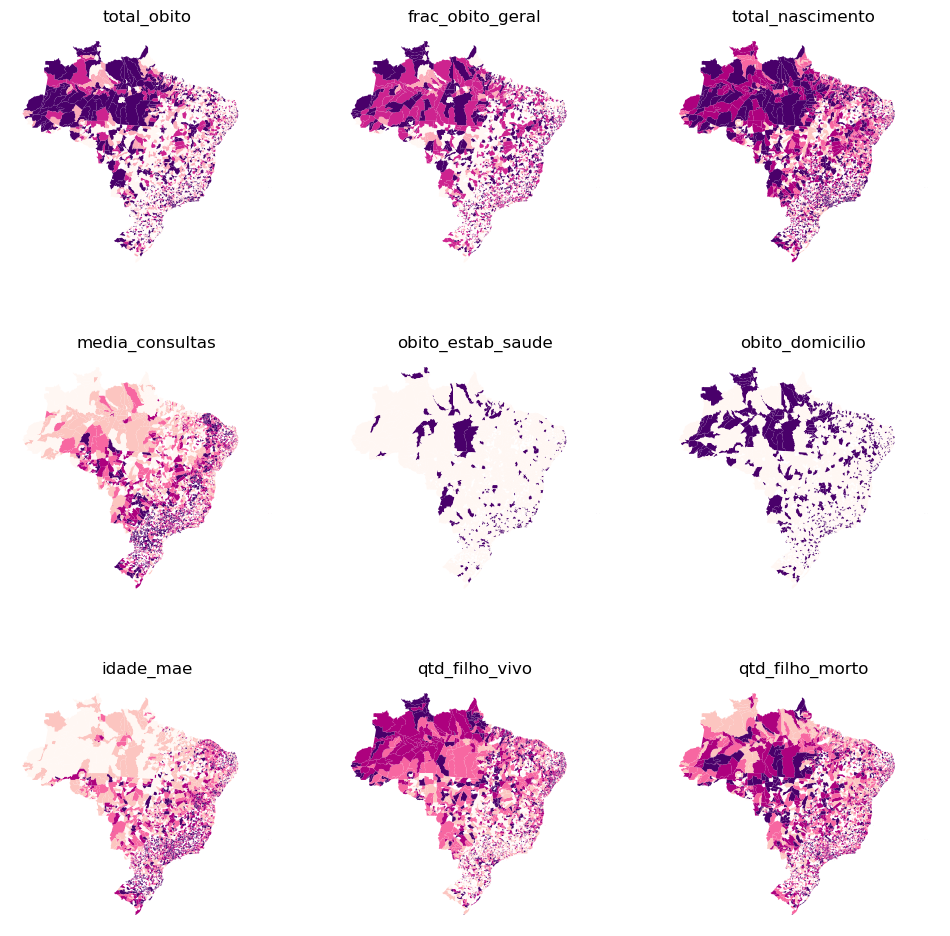

In [11]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

axs = axs.flatten()

for i, col in enumerate(interesting_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    ax.set_axis_off()
    ax.set_title(col)
plt.show()

The observation highlights a critical regional disparity in mortality rates, with the North of Brazil showing significantly worse outcomes compared to other areas. This pattern may be influenced by several factors, including:

Limited access to healthcare services

Lower socioeconomic indicators, such as education (escolarity)

Higher prevalence of risk factors, such as inadequate prenatal care (as indicated by low Kotelchuck Index)

### Focus in the North of Brazil

In [13]:
# Subset of Brazilian North states 
df_norte = df[df['CODMUN'].astype(str).str[:2].isin(['11', '12', '13', '14', '15', '16', '17'])]

In [160]:
df_norte['qtd_filho_morto'] = df_norte['qtd_filho_morto'].fillna(df_norte['qtd_filho_morto'].median())
df_norte['qtd_filho_vivo'] = df_norte['qtd_filho_vivo'].fillna(df_norte['qtd_filho_vivo'].median())
df_norte['idade_mae'] = df_norte['idade_mae'].fillna(df_norte['idade_mae'].median())
df_norte['media_consultas'] = df_norte['media_consultas'].fillna(df_norte['media_consultas'].median())
df_norte['sinasc_media_peso'] = df_norte['sinasc_media_peso'].fillna(df_norte['sinasc_media_peso'].median())
df_norte['sim_media_peso'] = df_norte['sim_media_peso'].fillna(df_norte['sim_media_peso'].median())

/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/911429763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norte['qtd_filho_morto'] = df_norte['qtd_filho_morto'].fillna(df_norte['qtd_filho_morto'].median())
/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/911429763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norte['qtd_filho_vivo'] = df_norte['qtd_filho_vivo'].fillna(df_norte['qtd_filho_vivo'].median())
/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipyker

In [14]:
gdf_norte = mapa.merge(df_norte, left_on='CD_MUN', right_on='CODMUN', how='right')

In [15]:
gdf_norte.head(2)

,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,CD_CONCURB,NM_CONCURB,AREA_KM2,geometry,CODMUN,total_obito,obito_hospital,obito_estab_saude,obito_domicilio,sim_media_peso,qtd_filho_morto,qtd_filho_vivo,sexo_masculino,sexo_feminino,gravidez_unica,gravidez_dupla,gravidez_tripla,parto_vaginal,parto_cesario,raca_branca,raca_preta,raca_amarela,raca_parda,raca_indigena,idade_mae,num_estabelecimentos,total_nascimento,nascimento_hospital,nascimento_estab_saude,nascimento_domicilio,media_consultas,sinasc_media_peso,total_geral,frac_obito_geral,perc_baixa_esc,perc_alta_esc,perc_baixo_kot,perc_alto_kot
0,110001,Alta Floresta D'Oeste,110005,Cacoal,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,7067.127,"POLYGON ((-61.93075 -11.97349, -61.93234 -11.9...",110001,0.0,0.0,0.0,0.0,NaN,0.228571,1.114286,0.771429,0.228571,1.000000,0.000000,0.0,0.285714,0.714286,0.200000,0.000000,0.000000,0.628571,0.142857,26.657143,2,35.0,1.000000,0.000000,0.0,8.200000,3209.000000,35.0,0.000000,0.228571,0.742857,0.257143,0.714286
1,110002,Ariquemes,110002,Ariquemes,1101,Porto Velho,11,Rondônia,1,Norte,None,None,4426.143,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...",110002,19.0,1.0,0.0,0.0,2215.315789,0.252853,0.920544,0.524583,0.475417,0.982002,0.017998,0.0,0.272608,0.727392,0.242318,0.066286,0.011853,0.677349,0.000878,26.413960,8,2259.0,0.998229,0.000885,0.0,8.689243,3219.460381,2278.0,0.008341,0.222125,0.776997,0.184152,0.814962


In [16]:
# Fill Nan
gdf_norte['qtd_filho_morto'] = gdf_norte['qtd_filho_morto'].fillna(gdf_norte['qtd_filho_morto'].median())
gdf_norte['qtd_filho_vivo'] = gdf_norte['qtd_filho_vivo'].fillna(gdf_norte['qtd_filho_vivo'].median())
gdf_norte['idade_mae'] = gdf_norte['idade_mae'].fillna(gdf_norte['idade_mae'].median())
gdf_norte['media_consultas'] = gdf_norte['media_consultas'].fillna(gdf_norte['media_consultas'].median())

In [ ]:
# Set the variables to standarize

variables = [
    'total_obito', 'obito_estab_saude', 'obito_domicilio',
    'sim_media_peso', 'qtd_filho_morto', 'qtd_filho_vivo', 'sexo_masculino', 
    'sexo_feminino', 'gravidez_unica', 'gravidez_dupla', 'gravidez_tripla', 
    'parto_vaginal', 'parto_cesario', 'raca_branca', 'raca_preta', 'raca_amarela', 
    'raca_parda', 'raca_indigena', 'idade_mae', 'num_estabelecimentos', 
    'total_nascimento', 'nascimento_estab_saude', 'nascimento_domicilio', 
    'media_consultas', 'sinasc_media_peso', 
    'total_geral', 'perc_baixa_esc', 'perc_alta_esc', 
    'perc_baixo_kot', 'perc_alto_kot'
]

In [17]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected variables
scaled_values = scaler.fit_transform(gdf_norte[variables])

# Create a DataFrame with the scaled values
scaled_df = pd.DataFrame(scaled_values, columns=variables, index=gdf_norte.index)

# Merge back into the GeoDataFrame
gdf_norte_scaled = gdf_norte.copy()
gdf_norte_scaled[variables] = scaled_df

In [112]:
gdf_norte_scaled

,CD_MUN,NM_MUN,CD_RGI,NM_RGI,CD_RGINT,NM_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,CD_CONCURB,NM_CONCURB,AREA_KM2,geometry,CODMUN,total_obito,obito_hospital,obito_estab_saude,obito_domicilio,sim_media_peso,qtd_filho_morto,qtd_filho_vivo,sexo_masculino,sexo_feminino,gravidez_unica,gravidez_dupla,gravidez_tripla,parto_vaginal,parto_cesario,raca_branca,raca_preta,raca_amarela,raca_parda,raca_indigena,idade_mae,num_estabelecimentos,total_nascimento,nascimento_hospital,nascimento_estab_saude,nascimento_domicilio,media_consultas,sinasc_media_peso,total_geral,frac_obito_geral,perc_baixa_esc,perc_alta_esc,perc_baixo_kot,perc_alto_kot,centroid,X,Y
0,110001,Alta Floresta D'Oeste,110005,Cacoal,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,7067.127,"POLYGON ((-61.93075 -11.97349, -61.93234 -11.9...",110001,-0.206300,0.000000,-0.215402,-0.457281,NaN,-0.027865,-0.789426,1.461679,-1.458869,0.255446,-0.266413,-0.173124,-1.413913,1.436922,1.006163,-0.479666,-0.199109,-0.516791,0.242630,0.709913,0.006861,-0.278114,1.000000,-0.338806,-0.462074,0.730797,0.245344,-0.276691,0.000000,-0.903972,0.946767,-0.580261,0.707845,POINT (-62.27466 -12.47013),-62.274661,-12.470132
1,110002,Ariquemes,110002,Ariquemes,1101,Porto Velho,11,Rondônia,1,Norte,None,None,4426.143,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...",110002,0.125774,1.000000,-0.215402,-0.457281,-0.223339,0.100686,-1.023142,0.083465,-0.081933,-0.016362,0.285973,-0.173124,-1.458110,1.481013,1.344870,0.220247,0.304944,-0.323128,-0.422756,0.614843,1.946940,0.584314,0.998229,-0.334823,-0.462074,1.020501,0.282534,0.574643,0.008341,-0.930918,1.087006,-0.892089,1.105499,POINT (-62.95724 -9.95188),-62.957245,-9.951880
2,110004,Cacoal,110005,Cacoal,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,3793.000,"POLYGON ((-61.00075 -11.25298, -61.0008 -11.29...",110004,0.003431,0.916667,-0.215402,-0.156541,-0.006358,0.041579,-1.117631,0.039020,-0.037529,0.024335,0.203266,-0.173124,-1.688712,1.709286,1.926927,0.110966,0.025309,-0.726609,-0.209239,0.998262,1.300247,0.438508,0.989910,-0.295809,-0.459490,1.265215,0.235982,0.429275,0.006332,-1.093974,1.248692,-1.050358,1.207078,POINT (-61.32473 -11.30129),-61.324729,-11.301287
3,110005,Cerejeiras,110006,Vilhena,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,2783.297,"POLYGON ((-60.82068 -13.11944, -60.81773 -13.1...",110005,-0.206300,0.000000,-0.215402,-0.457281,NaN,0.321559,-0.805725,0.357384,-0.355598,0.255446,-0.266413,-0.173124,-2.168242,2.189438,2.631760,-0.070405,-0.199109,-0.857988,-0.426871,0.543925,-0.316485,-0.241663,0.992248,-0.338806,-0.462074,1.154021,0.775525,-0.241013,0.000000,-1.049313,1.206969,-1.148937,1.346463,POINT (-61.26095 -13.20356),-61.260950,-13.203562
4,110006,Colorado do Oeste,110006,Vilhena,1102,Ji-Paraná,11,Rondônia,1,Norte,None,None,1451.063,"POLYGON ((-60.41495 -13.04076, -60.41445 -13.0...",110006,-0.206300,0.000000,-0.215402,-0.457281,NaN,-1.237951,-0.444761,0.504541,-0.502618,0.255446,-0.266413,-0.173124,0.994710,-0.965913,-0.594615,1.632124,-0.199109,-0.630230,-0.426871,-0.250683,-0.316485,-0.289748,0.400000,-0.338806,-0.462074,1.796662,0.128019,-0.288078,0.000000,-1.023393,1.181494,-0.824385,1.046400,POINT (-60.55024 -13.15915),-60.550245,-13.159153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,172100,Palmas,170001,Palmas,1701,Palmas,17,Tocantins,1,Norte,1721000,Palmas,2227.329,"POLYGON ((-48.31069 -10.4113, -48.31074 -10.41...",172100,2.467771,0.973856,-0.215402,-0.410106,-0.612537,0.282886,-0.894476,-0.016264,0.017704,-0.224371,0.679532,0.317358,-0.979543,0.999942,0.820329,0.538237,0.522669,-0.246401,-0.379783,1.188631,2.916979,2.505002,0.996672,-0.335687,-0.456678,1.061960,-0.061255,2.505421,0.020774,-1.409300,1.546253,-0.720958,0.891080,POINT (-48.15209 -10.22018),-48.152092,-10.220183
373,172110,Tocantínia,170004,Miracema do Tocantins,1701,Palmas,17,Tocantins,1,Nort

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


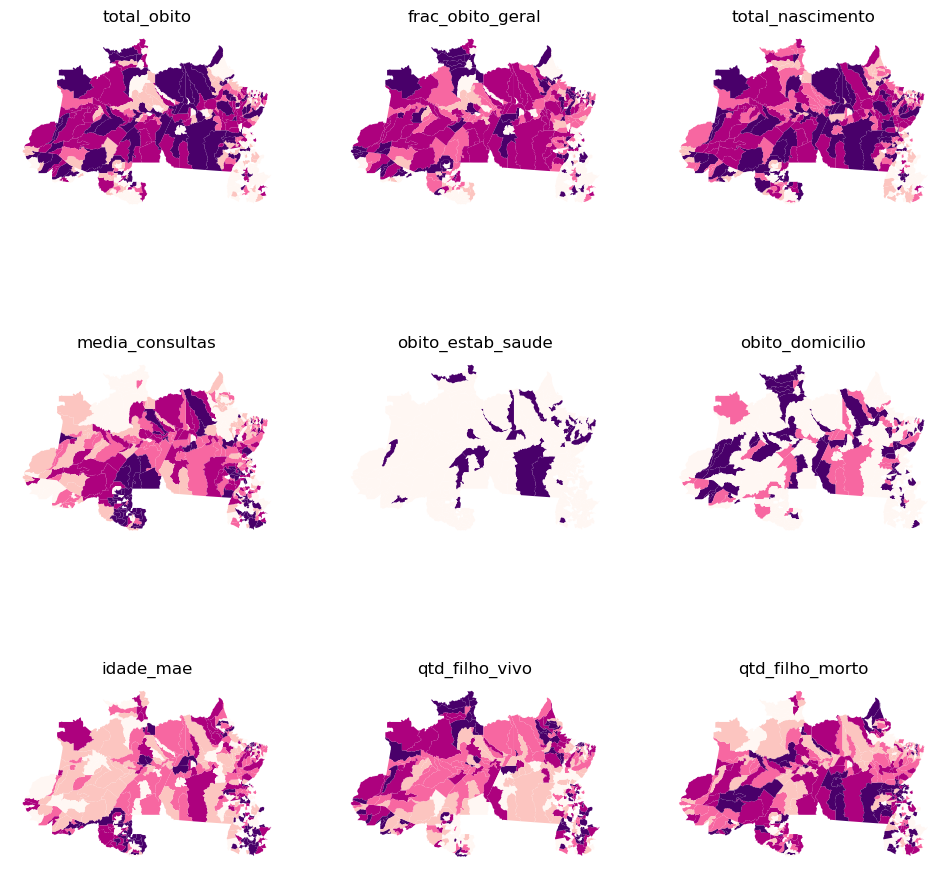

In [20]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

axs = axs.flatten()

for i, col in enumerate(interesting_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf_norte.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    ax.set_axis_off()
    ax.set_title(col)
plt.show()

### Geographic Clusters

In [260]:
#df_cluster = df_norte.drop(columns=['CODMUN', 'total_nascimento', 'total_obito', 'total_geral', 'sim_media_peso'])
df_cluster = df_norte.drop(columns=['CODMUN', 'sim_media_peso'])

In [262]:
df_cluster

,total_obito,obito_hospital,obito_estab_saude,obito_domicilio,qtd_filho_morto,qtd_filho_vivo,sexo_masculino,sexo_feminino,gravidez_unica,gravidez_dupla,gravidez_tripla,parto_vaginal,parto_cesario,raca_branca,raca_preta,raca_amarela,raca_parda,raca_indigena,idade_mae,num_estabelecimentos,total_nascimento,nascimento_hospital,nascimento_estab_saude,nascimento_domicilio,media_consultas,sinasc_media_peso,total_geral,frac_obito_geral,perc_baixa_esc,perc_alta_esc,perc_baixo_kot,perc_alto_kot,cluster_agg
0,0.0,0.000000,0.0,0.000000,0.228571,1.114286,0.771429,0.228571,1.000000,0.000000,0.000000,0.285714,0.714286,0.200000,0.000000,0.000000,0.628571,0.142857,26.657143,2,35.0,1.000000,0.000000,0.000000,8.200000,3209.000000,35.0,0.000000,0.228571,0.742857,0.257143,0.714286,1
1,19.0,1.000000,0.0,0.000000,0.252853,0.920544,0.524583,0.475417,0.982002,0.017998,0.000000,0.272608,0.727392,0.242318,0.066286,0.011853,0.677349,0.000878,26.413960,8,2259.0,0.998229,0.000885,0.000000,8.689243,3219.460381,2278.0,0.008341,0.222125,0.776997,0.184152,0.814962,1
2,12.0,0.916667,0.0,0.083333,0.241689,0.842216,0.516623,0.483377,0.984697,0.015303,0.000000,0.204222,0.795251,0.315040,0.055937,0.005277,0.575726,0.046438,27.394723,6,1883.0,0.989910,0.009559,0.000531,9.102509,3206.366968,1895.0,0.006332,0.183113,0.816359,0.147106,0.840680,1
3,0.0,0.000000,0.0,0.000000,0.294574,1.100775,0.573643,0.426357,1.000000,0.000000,0.000000,0.062016,0.937984,0.403101,0.038760,0.000000,0.542636,0.000000,26.232558,1,129.0,0.992248,0.000000,0.000000,8.914729,3358.124031,129.0,0.000000,0.193798,0.806202,0.124031,0.875969,1
4,0.0,0.000000,0.0,0.000000,0.000000,1.400000,0.600000,0.400000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.200000,0.000000,0.600000,0.000000,24.200000,1,5.0,0.400000,0.000000,0.000000,10.000000,3176.000000,5.0,0.000000,0.200000,0.800000,0.200000,0.800000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,153.0,0.973856,0.0,0.013072,0.287269,1.027203,0.506721,0.493279,0.968228,0.030821,0.000136,0.414528,0.584386,0.176782,0.096402,0.016972,0.696673,0.010048,27.881674,11,7212.0,0.996672,0.000693,0.001109,8.759259,3122.763034,7365.0,0.020774,0.107671,0.888798,0.224210,0.760677,1
373,0.0,0.000000,0.0,0.000000,0.222222,1.597122,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,17.000000,0,1.0,0.000000,0.000000,1.000000,7.227888,2700.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0
374,3.0,0.666667,0.0,0.000000,0.253112,1.605809,0.564315,0.435685,1.000000,0.000000,0.000000,0.771784,0.228216,0.095436,0.053942,0.004149,0.551867,0.294606,24.825726,2,238.0,0.962185,0.000000,0.016807,8.084034,3130.268908,241.0,0.012448,0.298755,0.701245,0.268908,0.731092,1
375,1.0,0.000000,0.0,1.000000,0.222222,1.222222,0.555556,0.444444,1.000000,0.000000,0.000000,0.888889,0.111111,0.000000,0.333333,0.000000,0.666667,0.000000,22.888889,0,8.0,0.000000,0.000000,0.000000,8.500000,3111.250000,9.0,0.111111,0.222222,0.777778,0.125000,0.875000,0


In [264]:
scaler = StandardScaler()
data_std = scaler.fit_transform(df_cluster)

In [266]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters_agg = agg.fit_predict(data_std)
df_cluster['cluster_agg'] = clusters_agg
df_cluster['cluster_agg'] = df_cluster['cluster_agg'].astype(str)

In [268]:
from matplotlib.colors import ListedColormap

palette = sns.color_palette('Set2', n_colors=len(set(clusters_agg)))

cmap = ListedColormap(palette.as_hex())

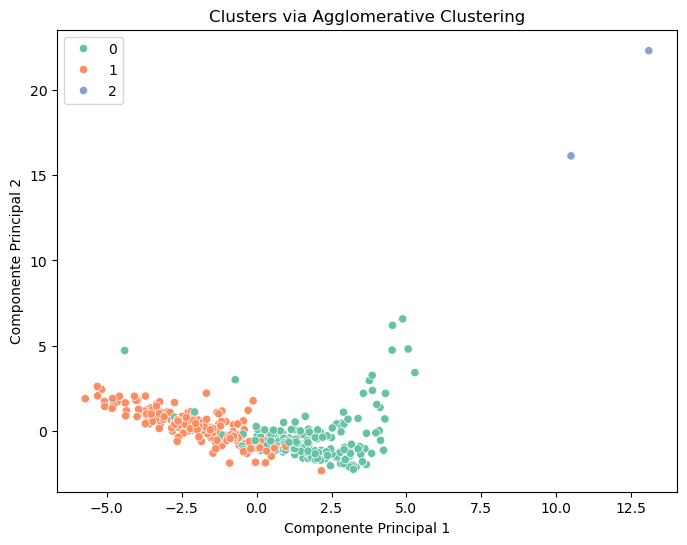

In [270]:
# Dimention reduction for 2D
pca = PCA(n_components=2)
reducao = pca.fit_transform(data_std)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reducao[:,0], y=reducao[:,1], hue=clusters_agg, palette=palette)
plt.title('Clusters via Agglomerative Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

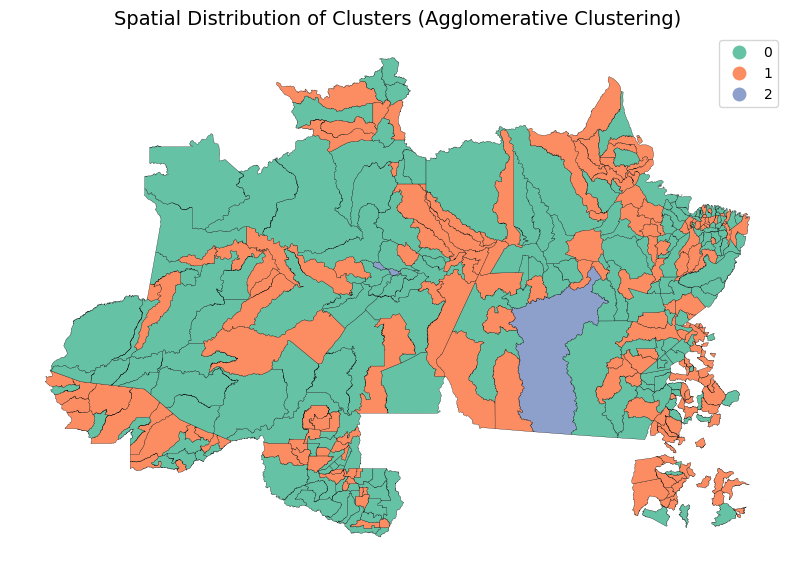

In [272]:
gdf_clusters = gdf.merge(df_cluster[['cluster_agg']], left_index=True, right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

gdf_clusters.plot(
    column='cluster_agg',
    cmap= cmap,  # Or 'tab10', 'Accent' — good qualitative color maps
    linewidth=0.2,
    edgecolor='black',
    legend=True,
    ax=ax
)

ax.set_title('Spatial Distribution of Clusters (Agglomerative Clustering)', fontsize=14)
ax.axis('off')

plt.show()

In [273]:
df_norte.loc[:, 'cluster_agg'] = clusters_agg
df_norte['cluster_agg'] = df_norte['cluster_agg'].astype(str)

/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/2062398565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norte['cluster_agg'] = df_norte['cluster_agg'].astype(str)


In [276]:
df_norte['cluster_agg'].value_counts()

cluster_agg
0    192
1    183
2      2
Name: count, dtype: int64

In [278]:
silhouette_score(df_cluster.drop(columns=['cluster_agg']), df_cluster['cluster_agg'])

0.12333960745793979

### GWR Model

In [21]:
gdf_norte_scaled['centroid'] = gdf_norte_scaled.geometry.centroid
gdf_norte_scaled['X'] = gdf_norte_scaled.centroid.x
gdf_norte_scaled['Y'] = gdf_norte_scaled.centroid.y

/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/682740068.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_norte_scaled['centroid'] = gdf_norte_scaled.geometry.centroid
/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/682740068.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_norte_scaled['X'] = gdf_norte_scaled.centroid.x
/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/682740068.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_norte_scaled['Y'] = gdf_norte_scaled.centroid.y


In [22]:
y = gdf_norte_scaled['frac_obito_geral'].values.reshape((-1,1))
y.shape

(377, 1)

In [23]:
independent_vars = [
    'obito_estab_saude',           # Deaths in other healthcare facilities
    'obito_domicilio',             # Deaths at home (proxy for poor access or late care)
    'qtd_filho_morto',             # Number of previous dead children (maternal risk factor)
    'qtd_filho_vivo',              # Fertility history (controls for exposure)
    'parto_cesario',               # Cesarean rates (related to healthcare system behavior)
    'raca_preta',                  # Racial composition (health disparities)
    'raca_parda',                  # Racial composition (health disparities)
    'idade_mae',                   # Maternal age (direct risk factor)
    'num_estabelecimentos',        # Number of health establishments (proxy for access)
    'total_nascimento',            # Total births (controls for exposure)
    'nascimento_estab_saude',      # Births in health establishments
    'nascimento_domicilio',        # Births at home (risk indicator)
    'media_consultas',             # Average prenatal consultations (access & quality)
    'perc_alta_esc',               # Proportion with high education (protective factor)
    'perc_alto_kot'                # Adequate prenatal care (Kotelchuck index high)
]

In [24]:
X = gdf_norte_scaled[independent_vars].values

In [25]:
coords = list(zip(gdf_norte_scaled['X'], gdf_norte_scaled['Y']))

# select the best band width
selector = Sel_BW(coords, y, X)
bw = selector.search()
print(f"Largura de banda escolhida: {bw}")

Largura de banda escolhida: 208.0


In [26]:
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                 377
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              3.012
Log-likelihood:                                                     375.453
AIC:                                                               -718.907
AICc:                                                              -715.202
BIC:                                                              -2138.529
R2:                                                                   0.263
Adj. R2:                                                              0.233

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Assuming your dataframe is gdf_norte and your independent variables list is independent_vars
X = gdf_norte[independent_vars]

# If needed, add a constant for intercept (statsmodels sometimes requires this)
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                  Variable         VIF
0                    const  129.886074
1        obito_estab_saude    1.125910
2          obito_domicilio    1.060713
3          qtd_filho_morto    1.152525
4           qtd_filho_vivo    2.549668
5            parto_cesario    2.016009
6               raca_preta    1.223191
7               raca_parda    1.269130
8                idade_mae    1.878757
9     num_estabelecimentos    6.860096
10        total_nascimento    6.512630
11  nascimento_estab_saude    1.217395
12    nascimento_domicilio    1.276486
13         media_consultas    2.643726
14           perc_alta_esc    1.583419
15           perc_alto_kot    2.891309


In [28]:
betas = gwr_results.params

gdf_norte.loc[:, 'beta_intercept'] = betas[:, 0]
gdf_norte.loc[:, 'beta_obito_estab_saude'] = betas[:, 1]
gdf_norte.loc[:, 'beta_obito_domicilio'] = betas[:, 2]
gdf_norte.loc[:, 'beta_qtd_filho_morto'] = betas[:, 3]
gdf_norte.loc[:, 'beta_qtd_filho_vivo'] = betas[:, 4]
gdf_norte.loc[:, 'beta_parto_cesario'] = betas[:, 5]
gdf_norte.loc[:, 'beta_raca_preta'] = betas[:, 6]
gdf_norte.loc[:, 'beta_raca_parda'] = betas[:, 7]
gdf_norte.loc[:, 'beta_idade_mae'] = betas[:, 8]
gdf_norte.loc[:, 'beta_num_estabelecimentos'] = betas[:, 9]
gdf_norte.loc[:, 'beta_total_nascimento'] = betas[:, 10]
gdf_norte.loc[:, 'beta_nascimento_estab_saude'] = betas[:, 11]
gdf_norte.loc[:, 'beta_nascimento_domicilio'] = betas[:, 12]
gdf_norte.loc[:, 'beta_media_consultas'] = betas[:, 13]
gdf_norte.loc[:, 'beta_perc_alta_esc'] = betas[:, 14]
gdf_norte.loc[:, 'beta_perc_alto_kot'] = betas[:, 15]

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


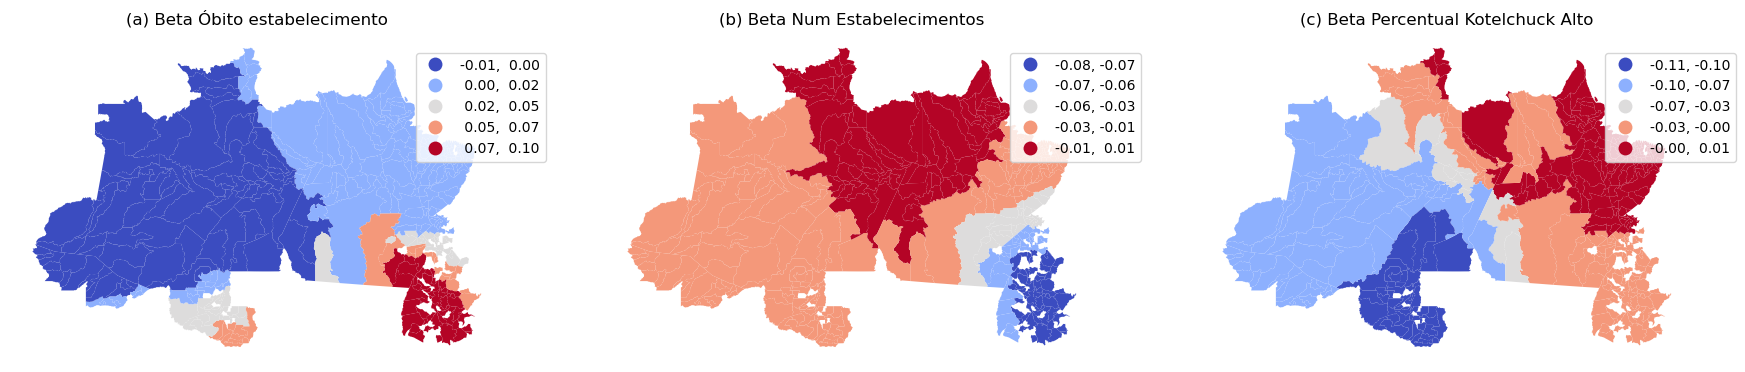

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

# (a) Mapa do beta_obito_hospital
gdf_norte.plot(
    column='beta_obito_estab_saude', 
    cmap='coolwarm', 
    linewidth=0.05, 
    scheme='FisherJenks', 
    k=5, 
    legend=True, 
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, 
    ax=axes[0]
)

# (b) Mapa do beta_num_estabelecimentos
gdf_norte.plot(
    column='beta_num_estabelecimentos', 
    cmap='coolwarm', 
    linewidth=0.05, 
    scheme='FisherJenks', 
    k=5, 
    legend=True, 
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, 
    ax=axes[1]
)

# (c) Mapa do beta_perc_alto_kot
gdf_norte.plot(
    column='beta_perc_alto_kot', 
    cmap='coolwarm', 
    linewidth=0.05, 
    scheme='FisherJenks', 
    k=5, 
    legend=True, 
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)}, 
    ax=axes[2]
)

# Layout
plt.tight_layout()

for ax in axes:
    ax.axis('off')

axes[0].set_title('(a) Beta Óbito estabelecimento', fontsize=12)
axes[1].set_title('(b) Beta Num Estabelecimentos', fontsize=12)
axes[2].set_title('(c) Beta Percentual Kotelchuck Alto', fontsize=12)

plt.show()


## MGWR

In [31]:
u = gdf_norte.geometry.centroid.x
v = gdf_norte.geometry.centroid.y
coords = list(zip(u, v))

/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/2490741409.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  u = gdf_norte.geometry.centroid.x
/var/folders/5p/kzljp9_d39g5r9ykrbtrg00m0000gn/T/ipykernel_92197/2490741409.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  v = gdf_norte.geometry.centroid.y


In [32]:
y = gdf_norte['frac_obito_geral'].values.reshape(-1, 1)
X = gdf_norte[independent_vars].values

In [33]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [34]:
mgwr_selector = Sel_BW(coords, y, X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])

print("Selected bandwidths for each variable:", mgwr_bw)

Selected bandwidths for each variable: [376. 181.  11. 376. 376. 283. 371.  14. 322. 288. 376. 376.  11. 138.
  15. 103.]


In [35]:
mgwr_model = MGWR(coords, y, X, selector=mgwr_selector, fixed=False, constant=True, spherical=True)
mgwr_results = mgwr_model.fit()

In [36]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 377
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            277.749
Log-likelihood:                                                    -477.348
AIC:                                                                986.696
AICc:                                                               990.400
BIC:                                                              -1863.792
R2:                                                                   0.263
Adj. R2:                                                              0.233

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [37]:
betas = mgwr_results.params

for i, col in enumerate(['intercept'] + independent_vars):
    gdf_norte[f'beta_{col}'] = betas[:, i]


/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


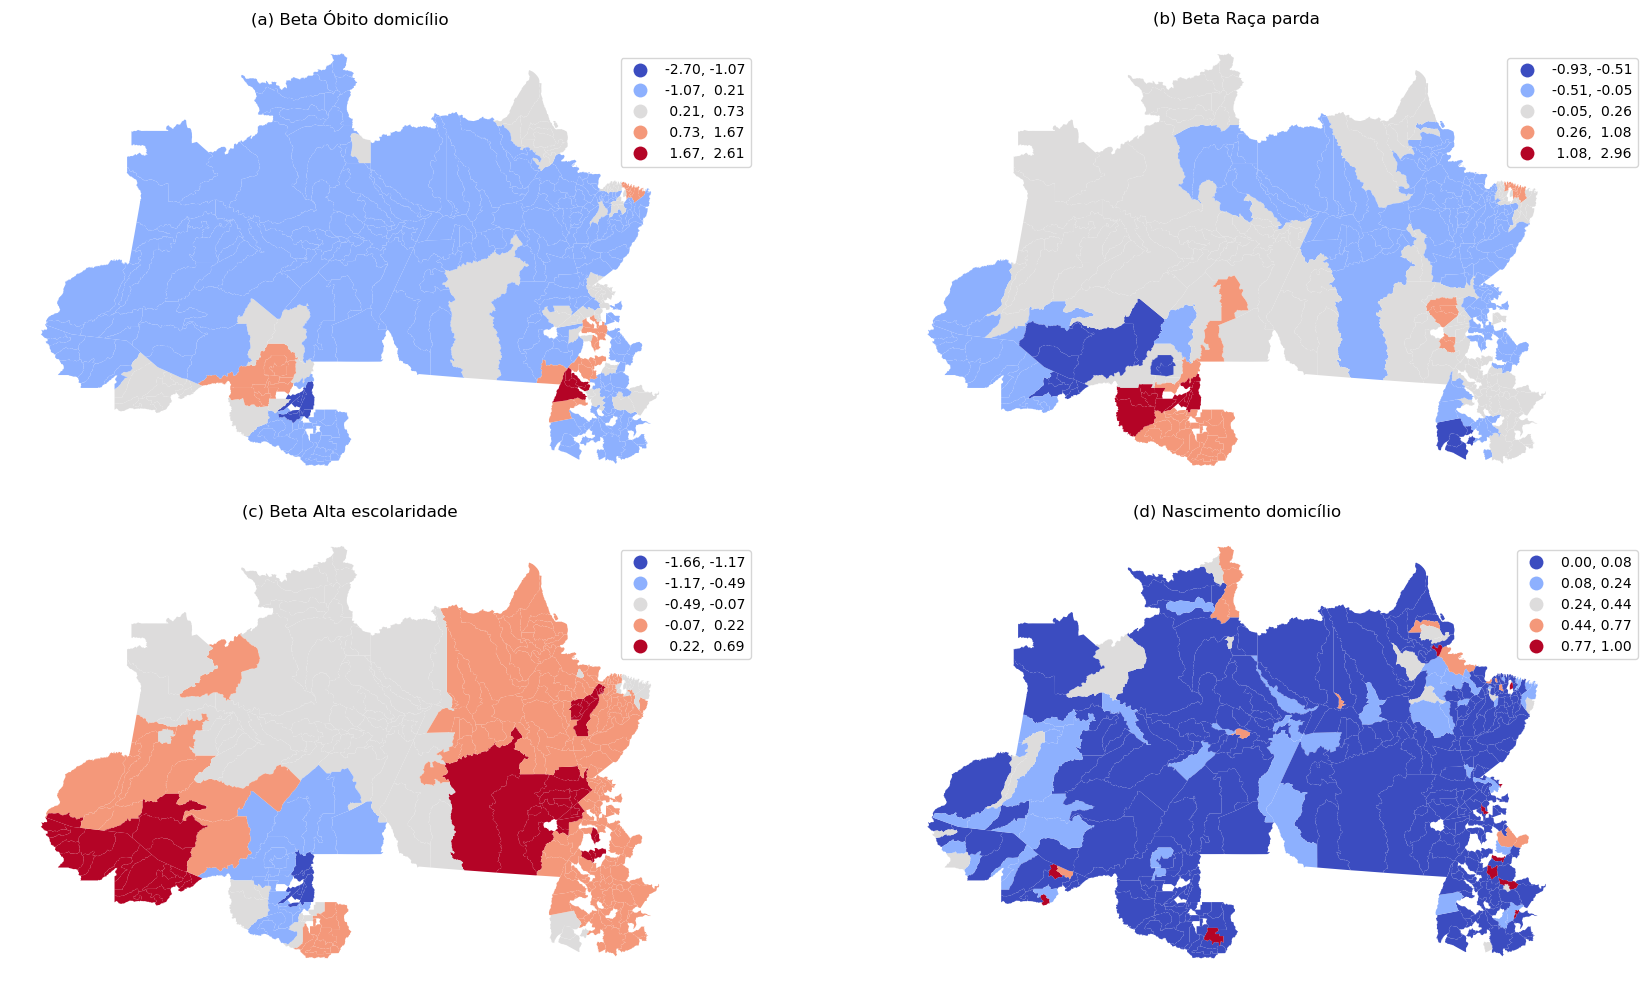

/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(
/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:752: UserWarning: Numba not installed. Using slow pure python version.
  binning = mapclassify.classify(


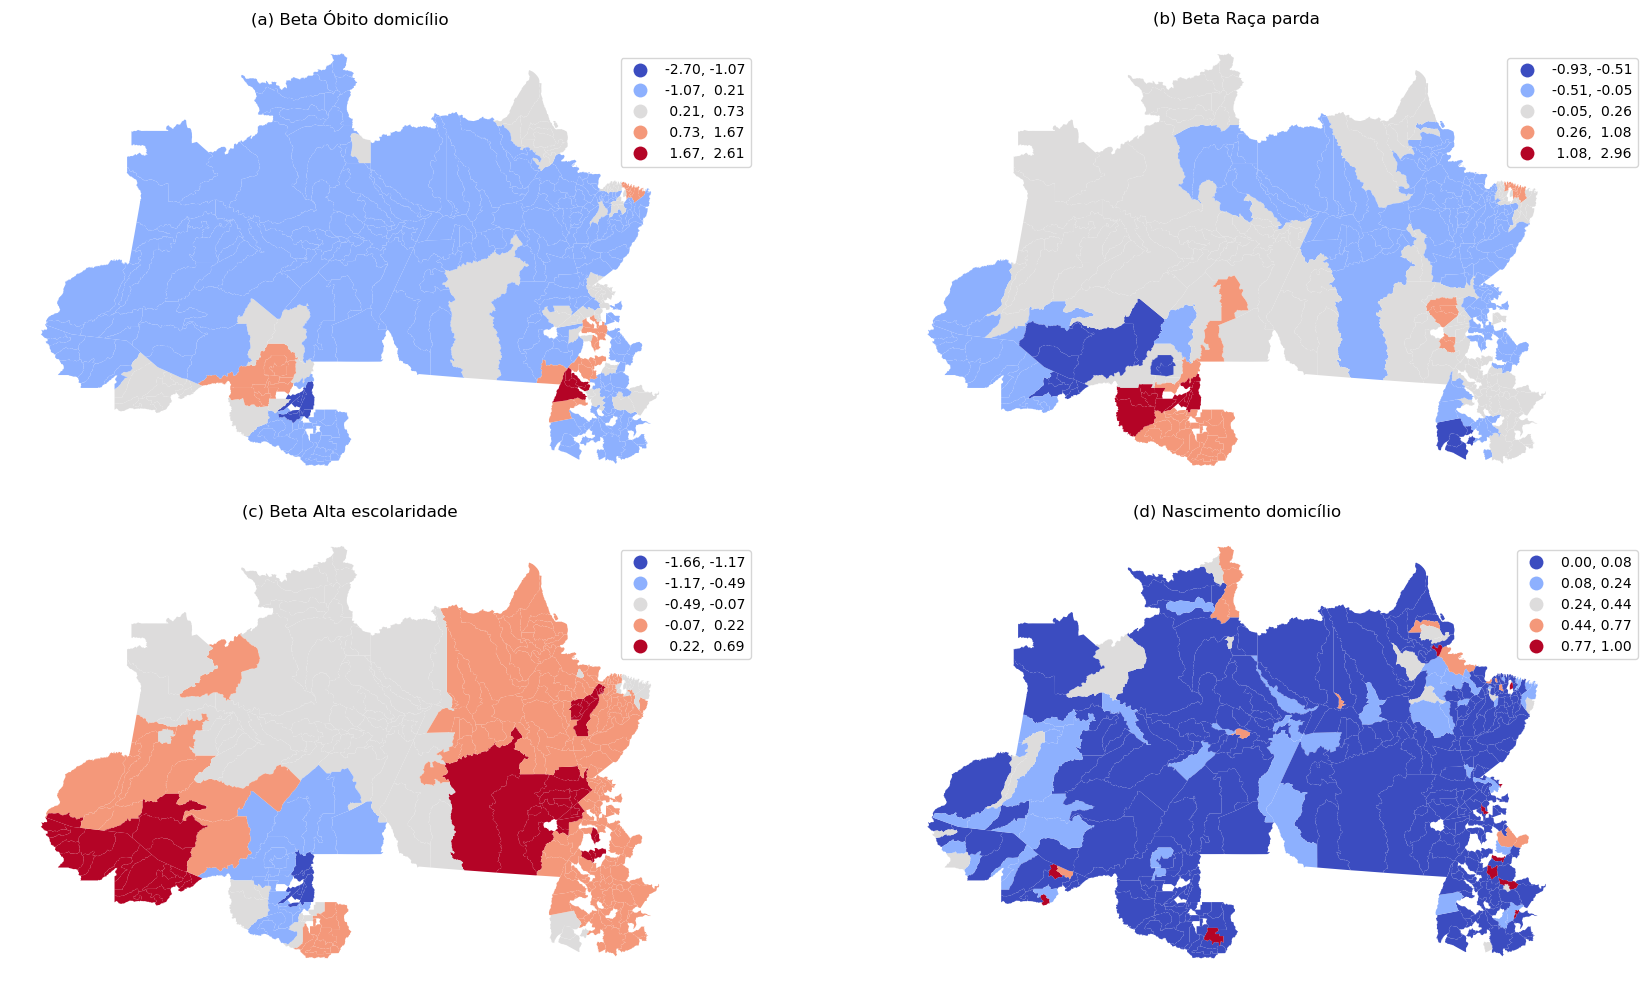

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

# (a) Beta Óbito Domicílio
gdf_norte.plot(
    column='beta_obito_domicilio',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[0, 0]
)

# (b) Beta Raça Parda
gdf_norte.plot(
    column='beta_raca_parda',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[0, 1]
)

# (c) Beta Alta Escolaridade
gdf_norte.plot(
    column='beta_perc_alta_esc',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[1, 0]
)

# (d) Nascimento Domicílio
gdf_norte.plot(
    column='nascimento_domicilio',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[1, 1]
)

# Layout
plt.tight_layout()

# Remove axes
for row in axes:
    for ax in row:
        ax.axis('off')

# Titles
axes[0, 0].set_title('(a) Beta Óbito domicílio', fontsize=12)
axes[0, 1].set_title('(b) Beta Raça parda', fontsize=12)
axes[1, 0].set_title('(c) Beta Alta escolaridade', fontsize=12)
axes[1, 1].set_title('(d) Nascimento domicílio', fontsize=12)

plt.show()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

# (a) Beta Óbito Domicílio
gdf_norte.plot(
    column='beta_obito_domicilio',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[0, 0]
)

# (b) Beta Raça Parda
gdf_norte.plot(
    column='beta_raca_parda',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[0, 1]
)

# (c) Beta Alta Escolaridade
gdf_norte.plot(
    column='beta_perc_alta_esc',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[1, 0]
)

# (d) Nascimento Domicílio
gdf_norte.plot(
    column='nascimento_domicilio',
    cmap='coolwarm',
    linewidth=0.05,
    scheme='FisherJenks',
    k=5,
    legend=True,
    legend_kwds={'bbox_to_anchor': (1.10, 0.96)},
    ax=axes[1, 1]
)

# Layout
plt.tight_layout()

# Remove axes
for row in axes:
    for ax in row:
        ax.axis('off')

# Titles
axes[0, 0].set_title('(a) Beta Óbito domicílio', fontsize=12)
axes[0, 1].set_title('(b) Beta Raça parda', fontsize=12)
axes[1, 0].set_title('(c) Beta Alta escolaridade', fontsize=12)
axes[1, 1].set_title('(d) Nascimento domicílio', fontsize=12)

plt.show()
